<a href="https://colab.research.google.com/github/Utree/deeplearning2_colab_log/blob/master/%E3%82%B9%E3%83%91%E3%82%A4%E3%83%A9%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class SGD:
  '''
  確率的勾配降下法(Stochastic Gradient Descent)
  '''
  def __init__(self, lr=0.01):
    self.lr = lr
    
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]

In [0]:
# データセットをインポート
def load_data(seed=1984):
  np.random.seed(seed)
  N = 100 # クラスごとのサンプル数
  DIM = 2 # データの要素数
  CLS_NUM = 3 # クラス数
  
  x = np.zeros((N*CLS_NUM, DIM))
  t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)
  
  for j in range(CLS_NUM):
    for i in range(N):
      rate = i / N
      radius = 1.0*rate
      theta = j*4.0 + 4.0*rate + np.random.randn()*0.2
      
      ix = N*j + i
      x[ix] = np.array([radius*np.sin(theta), radius*np.cos(theta)]).flatten()
      t[ix, j] = 1
  
  return x, t

In [0]:
# ソフトマックス関数
def softmax(x):
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))
    
  return x

In [0]:
# 交差エントロピー誤差
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  
  # 教師データがone-hot-vectorの場合、正解ベクトルのインデックスに変換
  if t.size == y.size:
    t = t.argmax(axis=1)
  
  batch_size = y.shape[0]
  
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [0]:
# Affineレイヤー
class Affine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.x = None
    
  def forward(self, x):
    W, b = self.params
    out = np.dot(x, W) + b
    self.x = x
    return out
  
  def backward(self, dout):
    W, b = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    db = np.sum(dout, axis=0)
    
    self.grads[0][...] = dW
    self.grads[1][...] = db
    return dx

In [0]:
# Softmax with Loss レイヤ
class SoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.y = None # softmaxの出力
    self.t = None # 教師ラベル
    
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    
    # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
    if self.t.size == self.y.size:
      self.t = self.t.argmax(axis=1)
    
    loss = cross_entropy_error(self.y, self.t)
    return loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    
    dx = self.y.copy()
    dx[np.arange(batch_size), self.t] -= 1
    dx *= dout
    dx = dx / batch_size
    
    return dx

In [0]:
# Sigmoidレイヤ
class Sigmoid:
  def __init__(self):
    self.params, self.grads = [], []
    self.out = None
    
  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out
  
  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

In [0]:
# TwoLayerNet
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size
    
    # 重みとバイアスの初期化
    W1 = 0.01 * np.random.randn(I, H)
    b1 = np.zeros(H)
    W2 = 0.01 * np.random.randn(H, O)
    b2 = np.zeros(O)
    
    # レイヤの生成
    self.layers = [
        Affine(W1, b1),
        Sigmoid(),
        Affine(W2, b2)
    ]
    self.loss_layer = SoftmaxWithLoss()
    
    # すべての重みと勾配をリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x
  
  def forward(self, x, t):
    score = self.predict(x)
    loss = self.loss_layer.forward(score, t)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

| epoch 1 | iter 10 / 10 | loss 1.13
| epoch 2 | iter 10 / 10 | loss 1.13
| epoch 3 | iter 10 / 10 | loss 1.12
| epoch 4 | iter 10 / 10 | loss 1.12
| epoch 5 | iter 10 / 10 | loss 1.11
| epoch 6 | iter 10 / 10 | loss 1.14
| epoch 7 | iter 10 / 10 | loss 1.16
| epoch 8 | iter 10 / 10 | loss 1.11
| epoch 9 | iter 10 / 10 | loss 1.12
| epoch 10 | iter 10 / 10 | loss 1.13
| epoch 11 | iter 10 / 10 | loss 1.12
| epoch 12 | iter 10 / 10 | loss 1.11
| epoch 13 | iter 10 / 10 | loss 1.09
| epoch 14 | iter 10 / 10 | loss 1.08
| epoch 15 | iter 10 / 10 | loss 1.04
| epoch 16 | iter 10 / 10 | loss 1.03
| epoch 17 | iter 10 / 10 | loss 0.96
| epoch 18 | iter 10 / 10 | loss 0.92
| epoch 19 | iter 10 / 10 | loss 0.92
| epoch 20 | iter 10 / 10 | loss 0.87
| epoch 21 | iter 10 / 10 | loss 0.85
| epoch 22 | iter 10 / 10 | loss 0.82
| epoch 23 | iter 10 / 10 | loss 0.79
| epoch 24 | iter 10 / 10 | loss 0.78
| epoch 25 | iter 10 / 10 | loss 0.82
| epoch 26 | iter 10 / 10 | loss 0.78
| epoch 27 | iter 10 

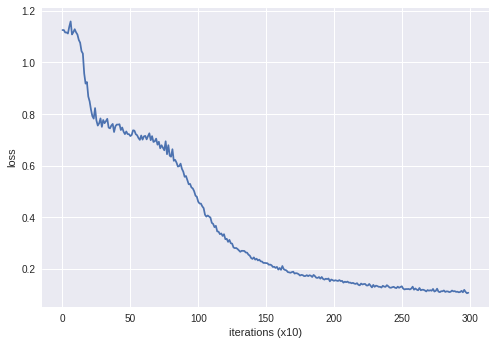

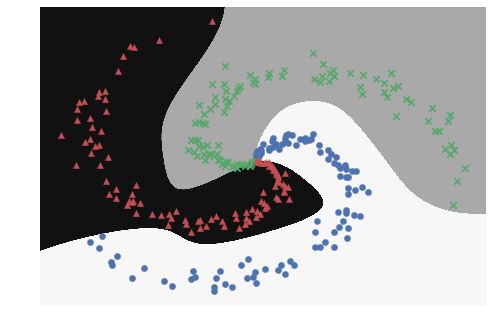

In [14]:
# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
  # データのシャッフル
  idx = np.random.permutation(data_size)
  x = x[idx]
  t = t[idx]
  
  for iters in range(max_iters):
    batch_x = x[iters*batch_size:(iters+1)*batch_size]
    batch_t = t[iters*batch_size:(iters+1)*batch_size]
    
    # 勾配を求め、パラメータを更新
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    
    total_loss += loss
    loss_count += 1
    
    # 定期的に学習経過を出力
    if (iters+1) % 10 == 0:
      avg_loss = total_loss / loss_count
      print('| epoch %d | iter %d / %d | loss %.2f' %(epoch+1, iters+1, max_iters, avg_loss))
      loss_list.append(avg_loss)
      total_loss, loss_count = 0, 0

# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
  plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()